# Meteor Project -  Meteors during the year

In this first script we will create an animation to see how the radiant distribution changes over time. Do we see certain patterns? Meteor showers? Let's see

## Get and prepare the data

The code part here is a compressed version from last time. In the last cell of this section we will add a new column that provides the Day of Year (DOY). We will iterate through the DOY (aggregated for all years) and create a DOY sky map of radiants.

In [1]:
# Importing libraries
from matplotlib import pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd

import datetime
import math
import os

In [2]:
# Read in the meteor data
df_orbit_compl = pd.read_csv("meteor_data/meteor_compl.csv",
                             index_col=0)
df_orbit_error = pd.read_csv("meteor_data/meteor_error.csv",
                             index_col=0)

df_radiants = pd.concat([df_orbit_compl[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]],
                         df_orbit_error[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]]])

# Now filter
df_radiants = df_radiants.loc[(df_radiants["Vg"]>=11) & (df_radiants["Vg"]<=73)].copy()

# Convert to radians
df_radiants.loc[:, "RA_rad"] = np.radians(df_radiants["RA"])
df_radiants.loc[:, "DECL_rad"] = np.radians(df_radiants["DECL"])

# Add a column for the plot
df_radiants.loc[:, 'RA_rad4plot'] = \
    df_radiants['RA_rad'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

# First we add a datetime object column:
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: datetime.datetime(year=int(x["Yr"]),
                                                  month=int(x["Mn"]),
                                                  day=math.floor(x["Dayy"])),
                                                  axis=1)

# Add now the day's fraction
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: x["datetime"] + datetime.timedelta(days=x["Dayy"]%1), axis=1)

In [3]:
# Add a Day of Year (DOY) column, based on the datetime column
df_radiants.loc[:, "doy"] = df_radiants.datetime.dt.day_of_year.copy()

## Creating the animation

MovieWriter ffmpeg unavailable; using Pillow instead.


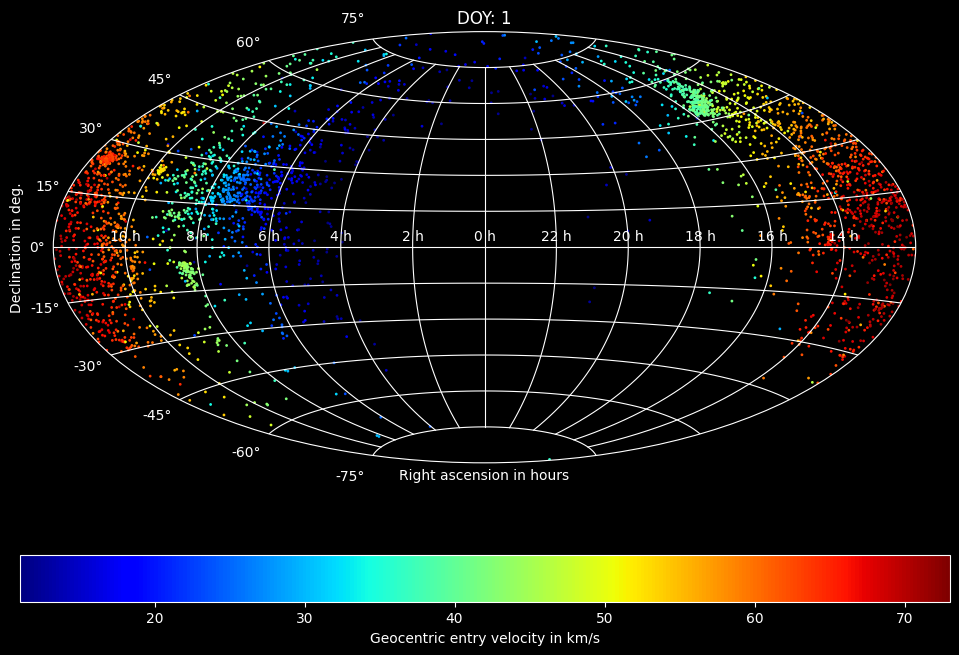

In [4]:
# Add some styles
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 8))

# Add aitoff projection
plt.subplot(projection="aitoff")

# Get axes
ax = plt.gca()

# Add a color for the velocity values
cm = plt.colormaps.get_cmap('jet')

filtered_df_radiants = df_radiants.loc[df_radiants["doy"]==0].copy()

# Plot the radiants
cr = plt.scatter(filtered_df_radiants['RA_rad4plot'], \
                 filtered_df_radiants['DECL_rad'], linestyle='None', \
                 s=1, c=filtered_df_radiants["Vg"], cmap=cm)

# Create a colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min(df_radiants["Vg"].values),
                                                       max(df_radiants["Vg"].values)))

# A function that creates a sky map per DOY
def update(frame):

    # Filter by the Day of Year
    filtered_df_radiants = df_radiants.loc[df_radiants["doy"]==frame+1].copy()

    # Add the radiants in the plot of the filtered dataframe
    cr.set_offsets(filtered_df_radiants[['RA_rad4plot', "DECL_rad"]])
    cr.set_array(filtered_df_radiants["Vg"])

    # Add a title that indicates the DOY
    ax.set_title(f"DOY: {frame+1}")
    
    return cr

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

# Add the colorbar
ax = plt.gca()
color_bar = fig.colorbar(sm, orientation='horizontal', ax=ax)
color_bar.set_alpha(1)
color_bar.set_label('Geocentric entry velocity in km/s')

ani = matplotlib.animation.FuncAnimation(fig=fig, func=update, frames=365, interval=100)

# Save the animation as a GIF file
ani.save('scatter_animation.gif')